In [4]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr

import warnings

warnings.simplefilter("ignore")

import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from sklearn.utils import shuffle
import tensorflow.keras.backend as kbackend
import tensorflow.keras.models
from keras.utils import np_utils
from keras.regularizers import l2

tf.compat.v1.disable_eager_execution()

import innvestigate
import innvestigate.utils as iutils

In [5]:
def basal_topology_func(x):
    b = 1.0 - 0.1*x
    return b

def solution(nx, nt, L, T, M, basal_topology_func):

    if len(M) != nx + 1:
        raise ValueError('M specified but len(M) != nx + 1')
        
    dx = L/nx
    dt = T/nt
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    b = basal_topology_func(x)

    A = 1e-16
    rho = 920.0
    g = 9.2 
    n = 3

    C = 2*A/(n+2) * (rho*g)**n * (1e3)**n

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = np.maximum(h[:,i] - b, 0.)

        if not np.any(H[:,i]>=0.0):
            raise Exception("Something went wrong.")
            
    Volume = np.sum(H)*dx
    
    return H[int(nx/2),-1], h[int(nx/2),-1], Volume

In [6]:
L = 30.
T = 10.
nx = 300
nt = 12000
samples = 1000

M_samples = 0.01*np.random.rand(samples, nx+1)
H_samples = np.zeros((samples,1), dtype = np.float64)
Volume_samples = np.zeros((samples,1), dtype = np.float64)

for sample in range(samples):
    if (sample+1) % 10 == 0:
        print(f"Sample #{sample+1}")
    H_samples[sample], _, Volume_samples[sample] = solution(nx, nt, L, T, M_samples[sample], basal_topology_func)

Sample #10
Sample #20
Sample #30
Sample #40
Sample #50
Sample #60
Sample #70
Sample #80
Sample #90
Sample #100
Sample #110
Sample #120
Sample #130
Sample #140
Sample #150
Sample #160
Sample #170
Sample #180
Sample #190
Sample #200
Sample #210
Sample #220
Sample #230
Sample #240
Sample #250
Sample #260
Sample #270
Sample #280
Sample #290
Sample #300
Sample #310
Sample #320
Sample #330
Sample #340
Sample #350
Sample #360
Sample #370
Sample #380
Sample #390
Sample #400
Sample #410
Sample #420
Sample #430
Sample #440
Sample #450
Sample #460
Sample #470
Sample #480
Sample #490
Sample #500
Sample #510
Sample #520
Sample #530
Sample #540
Sample #550
Sample #560
Sample #570
Sample #580
Sample #590
Sample #600
Sample #610
Sample #620
Sample #630
Sample #640
Sample #650
Sample #660
Sample #670
Sample #680
Sample #690
Sample #700
Sample #710
Sample #720
Sample #730
Sample #740
Sample #750
Sample #760
Sample #770
Sample #780
Sample #790
Sample #800
Sample #810
Sample #820
Sample #830
Sample #840
S

In [7]:
keras.backend.clear_session()

inputs = Input(shape=(nx+1,))
dense1 = Dense(10, activation='relu')
dense2 = Dense(1, activation='linear', use_bias=False)

x = dense1(inputs)
x = dense2(x)

model = keras.Model(inputs=inputs, outputs=x) 

mod_h5 = 'model.h5'

checkpoint = ModelCheckpoint(mod_h5, monitor='val_loss',
                             verbose=1,save_best_only=True)
        
callbacks = [checkpoint]
model.compile(optimizer='adam',
            loss='mse', metrics=['mae'])

fit = model.fit(M_samples, H_samples,
            batch_size=10,
            epochs=1000, 
            shuffle=True,
            validation_split = 0.2, 
            callbacks=callbacks)

Train on 800 samples, validate on 200 samples
Epoch 1/1000


2023-06-27 18:24:43.808114: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-1.4.43/installation/lib:/share/jdk-16.0.1/lib::
2023-06-27 18:24:43.808184: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-27 18:24:43.808229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c1-3): /proc/driver/nvidia/version does not exist
2023-06-27 18:24:43.808961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binar

640/800 [=======================>......] - ETA: 0s - loss: 9.9068e-04 - mae: 0.0253
Epoch 1: val_loss improved from inf to 0.00050, saving model to model.h5
800/800 [==============================] - 0s 464us/sample - loss: 8.8834e-04 - mae: 0.0239 - val_loss: 4.9839e-04 - val_mae: 0.0188
Epoch 2/1000
320/800 [===========>..................] - ETA: 0s - loss: 5.1000e-04 - mae: 0.0196

2023-06-27 18:24:44.167242: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/mul' id:88 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


600/800 [=====================>........] - ETA: 0s - loss: 4.9950e-04 - mae: 0.0190
Epoch 2: val_loss did not improve from 0.00050
800/800 [==============================] - 0s 196us/sample - loss: 5.0297e-04 - mae: 0.0191 - val_loss: 5.0800e-04 - val_mae: 0.0188
Epoch 3/1000
660/800 [=======================>......] - ETA: 0s - loss: 5.0518e-04 - mae: 0.0192
Epoch 3: val_loss improved from 0.00050 to 0.00049, saving model to model.h5
800/800 [==============================] - 0s 209us/sample - loss: 5.0315e-04 - mae: 0.0191 - val_loss: 4.9310e-04 - val_mae: 0.0186
Epoch 4/1000
700/800 [=========================>....] - ETA: 0s - loss: 4.9057e-04 - mae: 0.0190
Epoch 4: val_loss did not improve from 0.00049
800/800 [==============================] - 0s 178us/sample - loss: 4.8901e-04 - mae: 0.0189 - val_loss: 4.9344e-04 - val_mae: 0.0186
Epoch 5/1000
720/800 [==========================>...] - ETA: 0s - loss: 4.8538e-04 - mae: 0.0187
Epoch 5: val_loss improved from 0.00049 to 0.00048, sav

Epoch 30/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.1364e-04 - mae: 0.0086
Epoch 30: val_loss improved from 0.00019 to 0.00018, saving model to model.h5
800/800 [==============================] - 0s 186us/sample - loss: 1.1274e-04 - mae: 0.0086 - val_loss: 1.7553e-04 - val_mae: 0.0105
Epoch 31/1000
680/800 [========================>.....] - ETA: 0s - loss: 9.6010e-05 - mae: 0.0079
Epoch 31: val_loss improved from 0.00018 to 0.00017, saving model to model.h5
800/800 [==============================] - 0s 194us/sample - loss: 9.4918e-05 - mae: 0.0078 - val_loss: 1.6650e-04 - val_mae: 0.0105
Epoch 32/1000
630/800 [======================>.......] - ETA: 0s - loss: 1.0121e-04 - mae: 0.0081
Epoch 32: val_loss did not improve from 0.00017
800/800 [==============================] - 0s 183us/sample - loss: 9.8340e-05 - mae: 0.0080 - val_loss: 1.6935e-04 - val_mae: 0.0101
Epoch 33/1000
720/800 [==========================>...] - ETA: 0s - loss: 8.2726e-05 - mae: 0.0072
Epoch

670/800 [========================>.....] - ETA: 0s - loss: 2.9394e-05 - mae: 0.0044
Epoch 57: val_loss improved from 0.00007 to 0.00006, saving model to model.h5
800/800 [==============================] - 0s 204us/sample - loss: 2.8388e-05 - mae: 0.0043 - val_loss: 6.2121e-05 - val_mae: 0.0061
Epoch 58/1000
680/800 [========================>.....] - ETA: 0s - loss: 2.5739e-05 - mae: 0.0041
Epoch 58: val_loss improved from 0.00006 to 0.00006, saving model to model.h5
800/800 [==============================] - 0s 204us/sample - loss: 2.5183e-05 - mae: 0.0040 - val_loss: 6.0118e-05 - val_mae: 0.0060
Epoch 59/1000
670/800 [========================>.....] - ETA: 0s - loss: 2.6426e-05 - mae: 0.0042
Epoch 59: val_loss did not improve from 0.00006
800/800 [==============================] - 0s 180us/sample - loss: 2.6032e-05 - mae: 0.0041 - val_loss: 6.1485e-05 - val_mae: 0.0061
Epoch 60/1000
760/800 [===========================>..] - ETA: 0s - loss: 2.6099e-05 - mae: 0.0041
Epoch 60: val_loss 

690/800 [========================>.....] - ETA: 0s - loss: 2.0939e-05 - mae: 0.0036
Epoch 85: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 170us/sample - loss: 2.0651e-05 - mae: 0.0036 - val_loss: 6.0613e-05 - val_mae: 0.0062
Epoch 86/1000
750/800 [===========================>..] - ETA: 0s - loss: 2.1098e-05 - mae: 0.0037
Epoch 86: val_loss improved from 0.00005 to 0.00005, saving model to model.h5
800/800 [==============================] - 0s 183us/sample - loss: 2.0799e-05 - mae: 0.0037 - val_loss: 4.5906e-05 - val_mae: 0.0053
Epoch 87/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.9126e-05 - mae: 0.0035
Epoch 87: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 165us/sample - loss: 1.9147e-05 - mae: 0.0035 - val_loss: 5.1262e-05 - val_mae: 0.0056
Epoch 88/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8930e-05 - mae: 0.0035
Epoch 88: val_loss improved from 0.00005 to 0.000

Epoch 114/1000
650/800 [=======================>......] - ETA: 0s - loss: 2.0506e-05 - mae: 0.0036
Epoch 114: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 184us/sample - loss: 2.1279e-05 - mae: 0.0037 - val_loss: 4.8373e-05 - val_mae: 0.0056
Epoch 115/1000
650/800 [=======================>......] - ETA: 0s - loss: 1.8298e-05 - mae: 0.0035
Epoch 115: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 186us/sample - loss: 1.9361e-05 - mae: 0.0036 - val_loss: 4.7114e-05 - val_mae: 0.0053
Epoch 116/1000
730/800 [==========================>...] - ETA: 0s - loss: 1.8930e-05 - mae: 0.0035
Epoch 116: val_loss improved from 0.00004 to 0.00004, saving model to model.h5
800/800 [==============================] - 0s 186us/sample - loss: 1.9269e-05 - mae: 0.0035 - val_loss: 4.3828e-05 - val_mae: 0.0052
Epoch 117/1000
670/800 [========================>.....] - ETA: 0s - loss: 1.8482e-05 - mae: 0.0034
Epoch 117: val_loss did not 

Epoch 143/1000
770/800 [===========================>..] - ETA: 0s - loss: 2.0650e-05 - mae: 0.0037
Epoch 143: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 159us/sample - loss: 2.0550e-05 - mae: 0.0037 - val_loss: 4.4152e-05 - val_mae: 0.0052
Epoch 144/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.8755e-05 - mae: 0.0035
Epoch 144: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 159us/sample - loss: 1.8921e-05 - mae: 0.0035 - val_loss: 4.7490e-05 - val_mae: 0.0055
Epoch 145/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8569e-05 - mae: 0.0034
Epoch 145: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.8303e-05 - mae: 0.0034 - val_loss: 4.4269e-05 - val_mae: 0.0052
Epoch 146/1000
780/800 [============================>.] - ETA: 0s - loss: 1.8587e-05 - mae: 0.0034
Epoch 146: val_loss did not improve from 0.00004
800/800 [

770/800 [===========================>..] - ETA: 0s - loss: 1.8297e-05 - mae: 0.0034
Epoch 172: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.8585e-05 - mae: 0.0034 - val_loss: 4.9656e-05 - val_mae: 0.0055
Epoch 173/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.8395e-05 - mae: 0.0034
Epoch 173: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 166us/sample - loss: 1.9091e-05 - mae: 0.0035 - val_loss: 4.6533e-05 - val_mae: 0.0054
Epoch 174/1000
780/800 [============================>.] - ETA: 0s - loss: 1.9416e-05 - mae: 0.0035
Epoch 174: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.9252e-05 - mae: 0.0035 - val_loss: 5.0351e-05 - val_mae: 0.0055
Epoch 175/1000
660/800 [=======================>......] - ETA: 0s - loss: 2.0180e-05 - mae: 0.0036
Epoch 175: val_loss did not improve from 0.00004
800/800 [===============

720/800 [==========================>...] - ETA: 0s - loss: 1.8147e-05 - mae: 0.0034
Epoch 201: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 163us/sample - loss: 1.8400e-05 - mae: 0.0034 - val_loss: 4.5499e-05 - val_mae: 0.0052
Epoch 202/1000
780/800 [============================>.] - ETA: 0s - loss: 1.7955e-05 - mae: 0.0034
Epoch 202: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 155us/sample - loss: 1.7914e-05 - mae: 0.0034 - val_loss: 4.7266e-05 - val_mae: 0.0053
Epoch 203/1000
650/800 [=======================>......] - ETA: 0s - loss: 1.9517e-05 - mae: 0.0035
Epoch 203: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 189us/sample - loss: 1.9540e-05 - mae: 0.0035 - val_loss: 4.4514e-05 - val_mae: 0.0052
Epoch 204/1000
660/800 [=======================>......] - ETA: 0s - loss: 1.8555e-05 - mae: 0.0034
Epoch 204: val_loss did not improve from 0.00004
800/800 [===============

530/800 [==================>...........] - ETA: 0s - loss: 1.7096e-05 - mae: 0.0033
Epoch 230: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 112us/sample - loss: 1.7627e-05 - mae: 0.0034 - val_loss: 4.5351e-05 - val_mae: 0.0054
Epoch 231/1000
600/800 [=====================>........] - ETA: 0s - loss: 1.9482e-05 - mae: 0.0035
Epoch 231: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 103us/sample - loss: 1.9458e-05 - mae: 0.0035 - val_loss: 5.0471e-05 - val_mae: 0.0055
Epoch 232/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.9174e-05 - mae: 0.0035
Epoch 232: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.9943e-05 - mae: 0.0036 - val_loss: 4.5649e-05 - val_mae: 0.0053
Epoch 233/1000
470/800 [================>.............] - ETA: 0s - loss: 1.7810e-05 - mae: 0.0034
Epoch 233: val_loss did not improve from 0.00004
800/800 [===============

780/800 [============================>.] - ETA: 0s - loss: 2.1286e-05 - mae: 0.0037
Epoch 259: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 2.1632e-05 - mae: 0.0037 - val_loss: 4.4718e-05 - val_mae: 0.0053
Epoch 260/1000
800/800 [==============================] - ETA: 0s - loss: 1.7991e-05 - mae: 0.0034
Epoch 260: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 1.7991e-05 - mae: 0.0034 - val_loss: 4.4306e-05 - val_mae: 0.0053
Epoch 261/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.9694e-05 - mae: 0.0036
Epoch 261: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 164us/sample - loss: 1.9515e-05 - mae: 0.0035 - val_loss: 4.9098e-05 - val_mae: 0.0056
Epoch 262/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.9153e-05 - mae: 0.0034
Epoch 262: val_loss did not improve from 0.00004
800/800 [===============

750/800 [===========================>..] - ETA: 0s - loss: 1.9429e-05 - mae: 0.0036
Epoch 288: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 1.9830e-05 - mae: 0.0036 - val_loss: 4.7062e-05 - val_mae: 0.0053
Epoch 289/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.7543e-05 - mae: 0.0033
Epoch 289: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.8581e-05 - mae: 0.0034 - val_loss: 4.9452e-05 - val_mae: 0.0056
Epoch 290/1000
790/800 [============================>.] - ETA: 0s - loss: 1.8697e-05 - mae: 0.0035
Epoch 290: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 151us/sample - loss: 1.8563e-05 - mae: 0.0035 - val_loss: 4.4021e-05 - val_mae: 0.0052
Epoch 291/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.9188e-05 - mae: 0.0035
Epoch 291: val_loss did not improve from 0.00004
800/800 [===============

740/800 [==========================>...] - ETA: 0s - loss: 1.9201e-05 - mae: 0.0035
Epoch 317: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 163us/sample - loss: 1.9335e-05 - mae: 0.0035 - val_loss: 4.8368e-05 - val_mae: 0.0056
Epoch 318/1000
400/800 [==============>...............] - ETA: 0s - loss: 2.0567e-05 - mae: 0.0036
Epoch 318: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.9852e-05 - mae: 0.0035 - val_loss: 4.4159e-05 - val_mae: 0.0052
Epoch 319/1000
430/800 [===============>..............] - ETA: 0s - loss: 2.0655e-05 - mae: 0.0036
Epoch 319: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.8896e-05 - mae: 0.0035 - val_loss: 4.4869e-05 - val_mae: 0.0053
Epoch 320/1000
780/800 [============================>.] - ETA: 0s - loss: 2.2745e-05 - mae: 0.0039
Epoch 320: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.7195e-05 - mae: 0.0033
Epoch 346: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 1.8009e-05 - mae: 0.0034 - val_loss: 4.8504e-05 - val_mae: 0.0054
Epoch 347/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8591e-05 - mae: 0.0034
Epoch 347: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.7934e-05 - mae: 0.0034 - val_loss: 4.5601e-05 - val_mae: 0.0052
Epoch 348/1000
800/800 [==============================] - ETA: 0s - loss: 1.7718e-05 - mae: 0.0034
Epoch 348: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.7718e-05 - mae: 0.0034 - val_loss: 4.7671e-05 - val_mae: 0.0055
Epoch 349/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.6539e-05 - mae: 0.0032
Epoch 349: val_loss did not improve from 0.00004
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.7699e-05 - mae: 0.0033
Epoch 375: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 2.0203e-05 - mae: 0.0036 - val_loss: 4.6897e-05 - val_mae: 0.0053
Epoch 376/1000
800/800 [==============================] - ETA: 0s - loss: 2.2524e-05 - mae: 0.0039
Epoch 376: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 2.2524e-05 - mae: 0.0039 - val_loss: 5.5552e-05 - val_mae: 0.0060
Epoch 377/1000
410/800 [==============>...............] - ETA: 0s - loss: 2.0506e-05 - mae: 0.0036
Epoch 377: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 2.0213e-05 - mae: 0.0036 - val_loss: 4.7368e-05 - val_mae: 0.0053
Epoch 378/1000
790/800 [============================>.] - ETA: 0s - loss: 1.7711e-05 - mae: 0.0033
Epoch 378: val_loss did not improve from 0.00004
800/800 [===============

640/800 [=======================>......] - ETA: 0s - loss: 1.8096e-05 - mae: 0.0034
Epoch 404: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 181us/sample - loss: 1.8294e-05 - mae: 0.0034 - val_loss: 4.5382e-05 - val_mae: 0.0054
Epoch 405/1000
780/800 [============================>.] - ETA: 0s - loss: 1.8921e-05 - mae: 0.0035
Epoch 405: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 1.8917e-05 - mae: 0.0035 - val_loss: 4.4822e-05 - val_mae: 0.0053
Epoch 406/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.6927e-05 - mae: 0.0033
Epoch 406: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 1.7511e-05 - mae: 0.0033 - val_loss: 4.4793e-05 - val_mae: 0.0053
Epoch 407/1000
690/800 [========================>.....] - ETA: 0s - loss: 1.8667e-05 - mae: 0.0034
Epoch 407: val_loss did not improve from 0.00004
800/800 [===============

770/800 [===========================>..] - ETA: 0s - loss: 1.8788e-05 - mae: 0.0034
Epoch 433: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 155us/sample - loss: 1.8888e-05 - mae: 0.0034 - val_loss: 4.7221e-05 - val_mae: 0.0053
Epoch 434/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.9366e-05 - mae: 0.0035
Epoch 434: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 165us/sample - loss: 1.9437e-05 - mae: 0.0035 - val_loss: 5.2815e-05 - val_mae: 0.0058
Epoch 435/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.7278e-05 - mae: 0.0033
Epoch 435: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.8825e-05 - mae: 0.0034 - val_loss: 4.7858e-05 - val_mae: 0.0055
Epoch 436/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.6714e-05 - mae: 0.0032
Epoch 436: val_loss did not improve from 0.00004
800/800 [===============

610/800 [=====================>........] - ETA: 0s - loss: 1.7166e-05 - mae: 0.0033
Epoch 462: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 194us/sample - loss: 1.8236e-05 - mae: 0.0034 - val_loss: 4.4616e-05 - val_mae: 0.0052
Epoch 463/1000
630/800 [======================>.......] - ETA: 0s - loss: 1.7862e-05 - mae: 0.0033
Epoch 463: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 185us/sample - loss: 1.8049e-05 - mae: 0.0034 - val_loss: 4.5718e-05 - val_mae: 0.0054
Epoch 464/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.7984e-05 - mae: 0.0033
Epoch 464: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 173us/sample - loss: 1.8620e-05 - mae: 0.0034 - val_loss: 4.5609e-05 - val_mae: 0.0053
Epoch 465/1000
690/800 [========================>.....] - ETA: 0s - loss: 1.7590e-05 - mae: 0.0033
Epoch 465: val_loss did not improve from 0.00004
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.9134e-05 - mae: 0.0035
Epoch 492: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 1.9215e-05 - mae: 0.0035 - val_loss: 5.7085e-05 - val_mae: 0.0061
Epoch 493/1000
690/800 [========================>.....] - ETA: 0s - loss: 1.8653e-05 - mae: 0.0034
Epoch 493: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 170us/sample - loss: 1.8510e-05 - mae: 0.0034 - val_loss: 4.5232e-05 - val_mae: 0.0052
Epoch 494/1000
800/800 [==============================] - ETA: 0s - loss: 1.8510e-05 - mae: 0.0034
Epoch 494: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 1.8510e-05 - mae: 0.0034 - val_loss: 4.7489e-05 - val_mae: 0.0055
Epoch 495/1000
670/800 [========================>.....] - ETA: 0s - loss: 1.8179e-05 - mae: 0.0034
Epoch 495: val_loss did not improve from 0.00004
800/800 [===============

750/800 [===========================>..] - ETA: 0s - loss: 1.7841e-05 - mae: 0.0033
Epoch 521: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 1.7889e-05 - mae: 0.0034 - val_loss: 4.4829e-05 - val_mae: 0.0053
Epoch 522/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.9533e-05 - mae: 0.0035
Epoch 522: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.9467e-05 - mae: 0.0035 - val_loss: 4.4688e-05 - val_mae: 0.0052
Epoch 523/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.9741e-05 - mae: 0.0036
Epoch 523: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 166us/sample - loss: 1.9721e-05 - mae: 0.0036 - val_loss: 4.6232e-05 - val_mae: 0.0054
Epoch 524/1000
800/800 [==============================] - ETA: 0s - loss: 1.8926e-05 - mae: 0.0035
Epoch 524: val_loss did not improve from 0.00004
800/800 [===============

660/800 [=======================>......] - ETA: 0s - loss: 1.9137e-05 - mae: 0.0035
Epoch 550: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 179us/sample - loss: 1.9045e-05 - mae: 0.0035 - val_loss: 4.4633e-05 - val_mae: 0.0052
Epoch 551/1000
670/800 [========================>.....] - ETA: 0s - loss: 1.9638e-05 - mae: 0.0036
Epoch 551: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 178us/sample - loss: 1.8819e-05 - mae: 0.0035 - val_loss: 4.5569e-05 - val_mae: 0.0054
Epoch 552/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.7828e-05 - mae: 0.0034
Epoch 552: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 175us/sample - loss: 1.7829e-05 - mae: 0.0034 - val_loss: 4.4595e-05 - val_mae: 0.0052
Epoch 553/1000
640/800 [=======================>......] - ETA: 0s - loss: 1.8170e-05 - mae: 0.0034
Epoch 553: val_loss did not improve from 0.00004
800/800 [===============

640/800 [=======================>......] - ETA: 0s - loss: 1.8584e-05 - mae: 0.0035
Epoch 579: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 183us/sample - loss: 1.9787e-05 - mae: 0.0036 - val_loss: 5.0582e-05 - val_mae: 0.0057
Epoch 580/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.8309e-05 - mae: 0.0034
Epoch 580: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 171us/sample - loss: 1.7931e-05 - mae: 0.0034 - val_loss: 4.5193e-05 - val_mae: 0.0053
Epoch 581/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.7046e-05 - mae: 0.0033
Epoch 581: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 165us/sample - loss: 1.7192e-05 - mae: 0.0033 - val_loss: 4.8109e-05 - val_mae: 0.0054
Epoch 582/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.7475e-05 - mae: 0.0033
Epoch 582: val_loss did not improve from 0.00004
800/800 [===============

740/800 [==========================>...] - ETA: 0s - loss: 1.8704e-05 - mae: 0.0034
Epoch 608: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 161us/sample - loss: 1.8887e-05 - mae: 0.0034 - val_loss: 4.6496e-05 - val_mae: 0.0053
Epoch 609/1000
720/800 [==========================>...] - ETA: 0s - loss: 2.1725e-05 - mae: 0.0037
Epoch 609: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 174us/sample - loss: 2.1818e-05 - mae: 0.0037 - val_loss: 4.9128e-05 - val_mae: 0.0054
Epoch 610/1000
650/800 [=======================>......] - ETA: 0s - loss: 1.8974e-05 - mae: 0.0034
Epoch 610: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 188us/sample - loss: 1.8349e-05 - mae: 0.0034 - val_loss: 4.5007e-05 - val_mae: 0.0052
Epoch 611/1000
660/800 [=======================>......] - ETA: 0s - loss: 1.8230e-05 - mae: 0.0034
Epoch 611: val_loss did not improve from 0.00004
800/800 [===============

660/800 [=======================>......] - ETA: 0s - loss: 1.8620e-05 - mae: 0.0034
Epoch 637: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 185us/sample - loss: 1.8827e-05 - mae: 0.0034 - val_loss: 4.8353e-05 - val_mae: 0.0056
Epoch 638/1000
640/800 [=======================>......] - ETA: 0s - loss: 1.8476e-05 - mae: 0.0034
Epoch 638: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 183us/sample - loss: 1.8260e-05 - mae: 0.0034 - val_loss: 4.6161e-05 - val_mae: 0.0053
Epoch 639/1000
640/800 [=======================>......] - ETA: 0s - loss: 1.7636e-05 - mae: 0.0033
Epoch 639: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 185us/sample - loss: 1.7708e-05 - mae: 0.0034 - val_loss: 4.6930e-05 - val_mae: 0.0053
Epoch 640/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.7347e-05 - mae: 0.0033
Epoch 640: val_loss did not improve from 0.00004
800/800 [===============

380/800 [=============>................] - ETA: 0s - loss: 1.8307e-05 - mae: 0.0035
Epoch 666: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.7620e-05 - mae: 0.0033 - val_loss: 4.4717e-05 - val_mae: 0.0053
Epoch 667/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8656e-05 - mae: 0.0034
Epoch 667: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 1.7914e-05 - mae: 0.0034 - val_loss: 4.7921e-05 - val_mae: 0.0054
Epoch 668/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.7271e-05 - mae: 0.0033
Epoch 668: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 155us/sample - loss: 1.7394e-05 - mae: 0.0033 - val_loss: 4.5014e-05 - val_mae: 0.0053
Epoch 669/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.7399e-05 - mae: 0.0033
Epoch 669: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 2.1054e-05 - mae: 0.0037
Epoch 695: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 2.0025e-05 - mae: 0.0035 - val_loss: 4.4767e-05 - val_mae: 0.0053
Epoch 696/1000
780/800 [============================>.] - ETA: 0s - loss: 2.0221e-05 - mae: 0.0036
Epoch 696: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 2.0174e-05 - mae: 0.0036 - val_loss: 4.6036e-05 - val_mae: 0.0054
Epoch 697/1000
460/800 [================>.............] - ETA: 0s - loss: 1.6831e-05 - mae: 0.0032
Epoch 697: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 134us/sample - loss: 1.7970e-05 - mae: 0.0034 - val_loss: 4.5997e-05 - val_mae: 0.0054
Epoch 698/1000
460/800 [================>.............] - ETA: 0s - loss: 1.8380e-05 - mae: 0.0034
Epoch 698: val_loss did not improve from 0.00004
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.9640e-05 - mae: 0.0035
Epoch 724: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.8862e-05 - mae: 0.0035 - val_loss: 4.6143e-05 - val_mae: 0.0054
Epoch 725/1000
800/800 [==============================] - ETA: 0s - loss: 1.7846e-05 - mae: 0.0034
Epoch 725: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 151us/sample - loss: 1.7846e-05 - mae: 0.0034 - val_loss: 4.5598e-05 - val_mae: 0.0052
Epoch 726/1000
780/800 [============================>.] - ETA: 0s - loss: 1.7853e-05 - mae: 0.0034
Epoch 726: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 1.7940e-05 - mae: 0.0034 - val_loss: 4.4867e-05 - val_mae: 0.0053
Epoch 727/1000
690/800 [========================>.....] - ETA: 0s - loss: 1.7762e-05 - mae: 0.0033
Epoch 727: val_loss did not improve from 0.00004
800/800 [===============

760/800 [===========================>..] - ETA: 0s - loss: 1.7419e-05 - mae: 0.0033
Epoch 753: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 161us/sample - loss: 1.7657e-05 - mae: 0.0034 - val_loss: 5.6947e-05 - val_mae: 0.0059
Epoch 754/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.7465e-05 - mae: 0.0033
Epoch 754: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.7671e-05 - mae: 0.0033 - val_loss: 5.0305e-05 - val_mae: 0.0057
Epoch 755/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.8411e-05 - mae: 0.0034
Epoch 755: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.9286e-05 - mae: 0.0035 - val_loss: 4.5455e-05 - val_mae: 0.0054
Epoch 756/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.7665e-05 - mae: 0.0033
Epoch 756: val_loss did not improve from 0.00004
800/800 [===============

760/800 [===========================>..] - ETA: 0s - loss: 1.6875e-05 - mae: 0.0033
Epoch 782: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 1.6989e-05 - mae: 0.0033 - val_loss: 4.5180e-05 - val_mae: 0.0053
Epoch 783/1000
800/800 [==============================] - ETA: 0s - loss: 1.8164e-05 - mae: 0.0034
Epoch 783: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.8164e-05 - mae: 0.0034 - val_loss: 4.4579e-05 - val_mae: 0.0052
Epoch 784/1000
800/800 [==============================] - ETA: 0s - loss: 1.8669e-05 - mae: 0.0035
Epoch 784: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.8669e-05 - mae: 0.0035 - val_loss: 5.3948e-05 - val_mae: 0.0057
Epoch 785/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7550e-05 - mae: 0.0034
Epoch 785: val_loss did not improve from 0.00004
800/800 [===============

780/800 [============================>.] - ETA: 0s - loss: 1.7603e-05 - mae: 0.0034
Epoch 811: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 155us/sample - loss: 1.7456e-05 - mae: 0.0033 - val_loss: 4.4941e-05 - val_mae: 0.0052
Epoch 812/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.7159e-05 - mae: 0.0033
Epoch 812: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 166us/sample - loss: 1.6941e-05 - mae: 0.0033 - val_loss: 4.4295e-05 - val_mae: 0.0052
Epoch 813/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.6572e-05 - mae: 0.0033
Epoch 813: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.8147e-05 - mae: 0.0034 - val_loss: 4.8215e-05 - val_mae: 0.0056
Epoch 814/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8538e-05 - mae: 0.0034
Epoch 814: val_loss did not improve from 0.00004
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.8096e-05 - mae: 0.0034
Epoch 840: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.8434e-05 - mae: 0.0034 - val_loss: 4.6051e-05 - val_mae: 0.0054
Epoch 841/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.5717e-05 - mae: 0.0032
Epoch 841: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.9103e-05 - mae: 0.0035 - val_loss: 4.5163e-05 - val_mae: 0.0053
Epoch 842/1000
670/800 [========================>.....] - ETA: 0s - loss: 2.0373e-05 - mae: 0.0036
Epoch 842: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 183us/sample - loss: 2.0896e-05 - mae: 0.0037 - val_loss: 4.4079e-05 - val_mae: 0.0052
Epoch 843/1000
690/800 [========================>.....] - ETA: 0s - loss: 2.1546e-05 - mae: 0.0037
Epoch 843: val_loss did not improve from 0.00004
800/800 [===============

740/800 [==========================>...] - ETA: 0s - loss: 1.7079e-05 - mae: 0.0033
Epoch 869: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 163us/sample - loss: 1.7340e-05 - mae: 0.0033 - val_loss: 4.8076e-05 - val_mae: 0.0054
Epoch 870/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.6425e-05 - mae: 0.0032
Epoch 870: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 149us/sample - loss: 1.8124e-05 - mae: 0.0034 - val_loss: 4.7087e-05 - val_mae: 0.0055
Epoch 871/1000
800/800 [==============================] - ETA: 0s - loss: 2.3722e-05 - mae: 0.0039
Epoch 871: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 2.3722e-05 - mae: 0.0039 - val_loss: 4.6023e-05 - val_mae: 0.0054
Epoch 872/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.7308e-05 - mae: 0.0033
Epoch 872: val_loss did not improve from 0.00004
800/800 [===============

800/800 [==============================] - ETA: 0s - loss: 1.7499e-05 - mae: 0.0034
Epoch 898: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.7499e-05 - mae: 0.0034 - val_loss: 4.4753e-05 - val_mae: 0.0052
Epoch 899/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9196e-05 - mae: 0.0035
Epoch 899: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.7757e-05 - mae: 0.0034 - val_loss: 4.5692e-05 - val_mae: 0.0053
Epoch 900/1000
410/800 [==============>...............] - ETA: 0s - loss: 2.2940e-05 - mae: 0.0038
Epoch 900: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 2.0750e-05 - mae: 0.0036 - val_loss: 4.5787e-05 - val_mae: 0.0053
Epoch 901/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8605e-05 - mae: 0.0034
Epoch 901: val_loss did not improve from 0.00004
800/800 [===============

670/800 [========================>.....] - ETA: 0s - loss: 1.8619e-05 - mae: 0.0035
Epoch 927: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 177us/sample - loss: 1.8111e-05 - mae: 0.0034 - val_loss: 4.6223e-05 - val_mae: 0.0053
Epoch 928/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.9623e-05 - mae: 0.0035
Epoch 928: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 1.9707e-05 - mae: 0.0035 - val_loss: 4.4708e-05 - val_mae: 0.0053
Epoch 929/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.8035e-05 - mae: 0.0034
Epoch 929: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 167us/sample - loss: 1.8132e-05 - mae: 0.0034 - val_loss: 4.4738e-05 - val_mae: 0.0052
Epoch 930/1000
750/800 [===========================>..] - ETA: 0s - loss: 2.0521e-05 - mae: 0.0036
Epoch 930: val_loss did not improve from 0.00004
800/800 [===============

740/800 [==========================>...] - ETA: 0s - loss: 1.7814e-05 - mae: 0.0033
Epoch 956: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 1.7752e-05 - mae: 0.0034 - val_loss: 4.8818e-05 - val_mae: 0.0054
Epoch 957/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.9486e-05 - mae: 0.0035
Epoch 957: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 1.8815e-05 - mae: 0.0034 - val_loss: 5.5673e-05 - val_mae: 0.0060
Epoch 958/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.8877e-05 - mae: 0.0035
Epoch 958: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 1.8752e-05 - mae: 0.0035 - val_loss: 4.8426e-05 - val_mae: 0.0056
Epoch 959/1000
780/800 [============================>.] - ETA: 0s - loss: 1.9890e-05 - mae: 0.0036
Epoch 959: val_loss did not improve from 0.00004
800/800 [===============

410/800 [==============>...............] - ETA: 0s - loss: 1.8719e-05 - mae: 0.0035
Epoch 985: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.8945e-05 - mae: 0.0035 - val_loss: 4.4780e-05 - val_mae: 0.0052
Epoch 986/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.6439e-05 - mae: 0.0032
Epoch 986: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.7463e-05 - mae: 0.0033 - val_loss: 4.5448e-05 - val_mae: 0.0052
Epoch 987/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.8037e-05 - mae: 0.0034
Epoch 987: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 1.7005e-05 - mae: 0.0033 - val_loss: 4.5453e-05 - val_mae: 0.0053
Epoch 988/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.6098e-05 - mae: 0.0032
Epoch 988: val_loss did not improve from 0.00004
800/800 [===============

In [8]:
inputs = Input(shape=(nx+1,))
dense1 = Dense(10, activation='relu')
dense2 = Dense(1, activation='linear', use_bias=False)

x = dense1(inputs)
x = dense2(x)

best_model = keras.Model(inputs=inputs, outputs=x) 
best_model.load_weights(mod_h5)
best_model.compile(loss='mse', optimizer='adam',metrics=['mae'])

H_pred = best_model.predict(M_samples)

2023-06-27 18:26:53.093893: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/kernel/Assign' id:297 op device:{requested: '', assigned: ''} def:{{{node dense_2/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2/kernel, dense_2/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:26:53.163235: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_3/MatMul' id:324 op device:{requested: '', assigned: ''} def:{{{node dense_3/MatMul}} = MatMul[T=DT_FLOAT, _has_manual_control_dependencies=true, transpose_a=false, transpose_b=false](dense_2/Relu, dense_3/MatMul/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in 

In [9]:
analyzer_gradient = innvestigate.create_analyzer("lrp.alpha_1_beta_0", best_model)
a1g = np.zeros((samples, nx+1), dtype = np.float64)
for sample in range(samples):
    a1g[sample] = analyzer_gradient.analyze(M_samples[sample][np.newaxis,:])
    a1g[sample] /= np.max(np.abs(a1g[sample]))
    

2023-06-27 18:26:53.500514: W tensorflow/c/c_api.cc:291] Operation '{name:'kernel_3/Assign' id:489 op device:{requested: '', assigned: ''} def:{{{node kernel_3/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_3, kernel_3/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:26:53.540950: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients/MaxNeuronSelection/Max_grad/range' id:499 op device:{requested: '', assigned: ''} def:{{{node gradients/MaxNeuronSelection/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection/Max"], _has_manual_control_dependencies=true](gradients/MaxNeuronSelection/Max_grad/range/start, gradients/MaxNeuronSelection/Max_grad/Size, gradients/MaxNeuronSelection/Max_grad/range

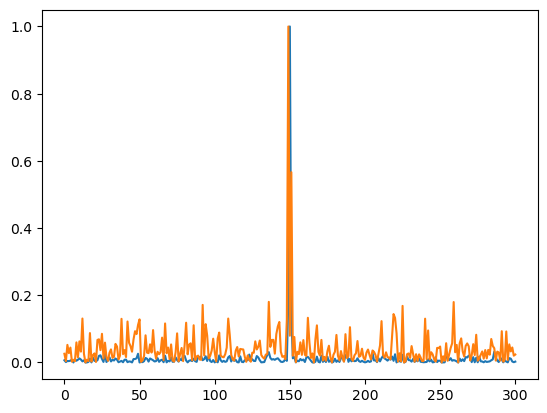

In [10]:
plt.plot(a1g[0])
plt.plot(a1g[10])

In [11]:
analyzer_gradient = innvestigate.create_analyzer("lrp.z", best_model)
a1g = np.zeros((samples, nx+1), dtype = np.float64)
for sample in range(samples):
    a1g[sample] = analyzer_gradient.analyze(M_samples[sample][np.newaxis,:])
    a1g[sample] /= np.max(np.abs(a1g[sample]))
    

2023-06-27 18:26:55.325086: W tensorflow/c/c_api.cc:291] Operation '{name:'kernel_4/Assign' id:605 op device:{requested: '', assigned: ''} def:{{{node kernel_4/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_4, kernel_4/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:26:55.361018: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients_5/MaxNeuronSelection_1/Max_grad/range' id:634 op device:{requested: '', assigned: ''} def:{{{node gradients_5/MaxNeuronSelection_1/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_1/Max"], _has_manual_control_dependencies=true](gradients_5/MaxNeuronSelection_1/Max_grad/range/start, gradients_5/MaxNeuronSelection_1/Max_grad/Size, gradients_5/MaxNeuronSele

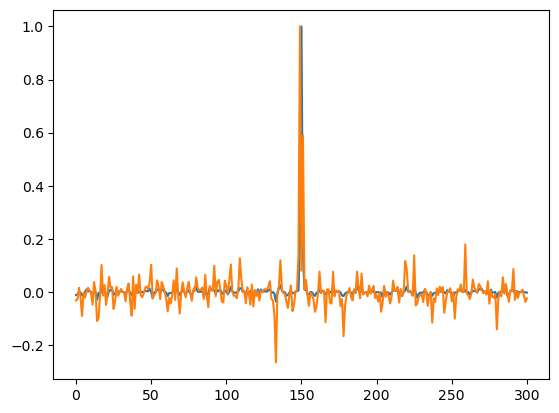

In [12]:
plt.plot(a1g[0])
plt.plot(a1g[10])

In [16]:
def regression_letzgus(model, input_, y_ref, step_width=0.00005, max_it=10e4, method = "flood"):
    
    ### Finding a_ref for a given y_ref
    
    if method == "flood":
        
        model_part = Model(inputs=model.input,
                          outputs=model.layers[-2].output)
        a_ref = model_part.predict(input_)[0,:]
        a_ref = a_ref[:, np.newaxis]
        update = np.ones(a_ref.shape) * step_width
        
        y = model.predict(input_)
        
        counter = 0
        
        if y > y_ref:
            
            while y >= y_ref:
                
                a_ref = np.maximum(np.zeros(a_ref.shape),a_ref-update)
                y = np.dot(model.layers[-1].get_weights()[0][:,0], a_ref[:,0])
                counter +=1 
                print(f'iteration {counter} - y: {y}', end='\r')
                if counter > max_it:
                    print(f'! reference value {y_ref} was not reached within {round(max_it)} iterations!')
                    break
        else:
            
            while y <= y_ref:
                
                a_ref = np.maximum(np.zeros(a_ref.shape),a_ref+update)
                y = np.dot(model.layers[-1].get_weights()[0][:,0], a_ref[:,0])
                counter +=1 
                print(f'iteration {counter} - y: {y}', end='\r')
                if counter > max_it:
                    print(f'! reference value {y_ref} was not reached within {round(max_it)} iterations!')
                    break
                    
    else: 
        
        raise ValueError("The only methods available are : flood")
        
    return a_ref

def triplicated_model(best_model, a_ref):
    
    # get weights and biases
    W_in = best_model.layers[-2].get_weights()[0]
    W_out = best_model.layers[-1].get_weights()[0]
    bias_in = best_model.layers[-2].get_weights()[1]

    inputs = Input(shape=(nx+1,))

    # layer_dict = dict([(layer.name, layer) for layer in model.layers[:-2]])
    # weights = layer_dict['some_name'].get_weights()

    dense11 = Dense(10, activation='relu', name='dense11')
    dense12 = Dense(10, activation='relu', name='dense12')
    dense13 = Dense(10, activation='relu', name='dense13')
    dense21 = Dense(1, activation='linear', use_bias=False, name='dense21')
    dense22 = Dense(1, activation='linear', use_bias=False, name='dense22')
    dense23 = Dense(1, activation='linear', use_bias=False, name='dense23')

    x1 = dense11(inputs)
    x2 = dense12(inputs)
    x3 = dense13(inputs)

    x1 = dense21(x1)
    x2 = dense22(x2)
    x3 = dense23(x3)

    model = keras.Model(inputs=inputs, outputs=x1+x2+x3) 
    
    def getLayerIndexByName(model, layername):
        for idx, layer in enumerate(model.layers):
            if layer.name == layername:
                return idx
            
    model.layers[getLayerIndexByName(model, 'dense11')].set_weights([W_in, bias_in-a_ref[:,0]])
    model.layers[getLayerIndexByName(model, 'dense12')].set_weights([-W_in, -bias_in])                 
    model.layers[getLayerIndexByName(model, 'dense13')].set_weights([-W_in, -bias_in+a_ref[:,0]])
    
    model.layers[getLayerIndexByName(model, 'dense21')].set_weights([W_out])
    model.layers[getLayerIndexByName(model, 'dense22')].set_weights([W_out])
    model.layers[getLayerIndexByName(model, 'dense23')].set_weights([-W_out])
    
    model.compile(loss='mse', optimizer='adam',metrics=['mae'])
    
    return model

In [18]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y / 2.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, index], y_ref)

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
tri_model = triplicated_model(model_reg, a_ref)
y_reg = tri_model.predict(M_samples[np.newaxis, index])


y_ref, y-y_reg, y, y_reg

2023-06-27 18:28:57.563490: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Relu' id:308 op device:{requested: '', assigned: ''} def:{{{node dense_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:28:57.605560: W tensorflow/c/c_api.cc:291] Operation '{name:'count_9/Assign' id:1357 op device:{requested: '', assigned: ''} def:{{{node count_9/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_9, count_9/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:28:57.659795: W tensor

2023-06-27 18:28:57.903310: W tensorflow/c/c_api.cc:291] Operation '{name:'total_10/Assign' id:1401 op device:{requested: '', assigned: ''} def:{{{node total_10/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_10, total_10/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:28:58.105950: W tensorflow/c/c_api.cc:291] Operation '{name:'dense11_2/bias/Assign' id:1462 op device:{requested: '', assigned: ''} def:{{{node dense11_2/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense11_2/bias, dense11_2/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't

(array([[0.03797401]], dtype=float32),
 array([[0.03795838]], dtype=float32),
 array([[0.07594802]], dtype=float32),
 array([[0.03798965]], dtype=float32))

In [19]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y * 2.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, index], y_ref)

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
tri_model = triplicated_model(model_reg, a_ref)
y_reg = tri_model.predict(M_samples[np.newaxis, index])

y_ref, y-y_reg, y, y_reg

2023-06-27 18:28:58.634970: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Relu' id:308 op device:{requested: '', assigned: ''} def:{{{node dense_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:28:58.686442: W tensorflow/c/c_api.cc:291] Operation '{name:'total_12/Assign' id:1656 op device:{requested: '', assigned: ''} def:{{{node total_12/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_12, total_12/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:28:58.751168: W te

2023-06-27 18:28:59.240521: W tensorflow/c/c_api.cc:291] Operation '{name:'total_13/Assign' id:1705 op device:{requested: '', assigned: ''} def:{{{node total_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_13, total_13/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:28:59.466205: W tensorflow/c/c_api.cc:291] Operation '{name:'dense21_3/kernel/Assign' id:1833 op device:{requested: '', assigned: ''} def:{{{node dense21_3/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense21_3/kernel, dense21_3/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error 

(array([[0.15189604]], dtype=float32),
 array([[0.15192938]], dtype=float32),
 array([[0.07594802]], dtype=float32),
 array([[-0.07598135]], dtype=float32))

In [20]:
def triplicated_model_LRP_compatible(best_model, a_ref):
    
    # get weights and biases
    W_in = best_model.layers[-2].get_weights()[0]
    W_out = best_model.layers[-1].get_weights()[0]
    bias_in = best_model.layers[-2].get_weights()[1]

    inputs = Input(shape=(nx+1,))

    # layer_dict = dict([(layer.name, layer) for layer in model.layers[:-2]])
    # weights = layer_dict['some_name'].get_weights()

    dense11 = Dense(10, activation='relu', name='dense11')
    dense12 = Dense(10, activation='relu', name='dense12')
    dense13 = Dense(10, activation='relu', name='dense13')
    dense21 = Dense(1, activation='linear', use_bias=False, name='dense21')
    dense22 = Dense(1, activation='linear', use_bias=False, name='dense22')
    dense23 = Dense(1, activation='linear', use_bias=False, name='dense23')

    x1 = dense11(inputs)
    x2 = dense12(inputs)
    x3 = dense13(inputs)

    x1 = dense21(x1)
    x2 = dense22(x2)
    x3 = dense23(x3)

    model1 = keras.Model(inputs=inputs, outputs=x1)
    model2 = keras.Model(inputs=inputs, outputs=x2) 
    model3 = keras.Model(inputs=inputs, outputs=x3) 
    
    def getLayerIndexByName(model, layername):
        for idx, layer in enumerate(model.layers):
            if layer.name == layername:
                return idx
            
    model1.layers[getLayerIndexByName(model1, 'dense11')].set_weights([W_in, bias_in-a_ref[:,0]])
    model2.layers[getLayerIndexByName(model2, 'dense12')].set_weights([-W_in, -bias_in])                 
    model3.layers[getLayerIndexByName(model3, 'dense13')].set_weights([-W_in, -bias_in+a_ref[:,0]])
    
    model1.layers[getLayerIndexByName(model1, 'dense21')].set_weights([W_out])
    model2.layers[getLayerIndexByName(model2, 'dense22')].set_weights([W_out])
    model3.layers[getLayerIndexByName(model3, 'dense23')].set_weights([-W_out])
    
    model1.compile(loss='mse', optimizer='adam',metrics=['mae'])
    model2.compile(loss='mse', optimizer='adam',metrics=['mae'])
    model3.compile(loss='mse', optimizer='adam',metrics=['mae'])
    
    return model1, model2, model3

In [21]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y * 2.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, 0], y_ref)

model1, model2, model3 = triplicated_model_LRP_compatible(best_model, a_ref)
y1 = model1.predict(M_samples[np.newaxis, index])
y2 = model1.predict(M_samples[np.newaxis, index])
y3 = model1.predict(M_samples[np.newaxis, index])

analyzer_gradient1 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model1)
analyzer_gradient2 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model2)
analyzer_gradient3 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model3)
a1 = np.zeros((samples, nx+1), dtype = np.float64)
a2 = np.zeros((samples, nx+1), dtype = np.float64)
a3 = np.zeros((samples, nx+1), dtype = np.float64)
a  = np.zeros((samples, nx+1), dtype = np.float64)

for sample in range(samples):
    a1[sample] = analyzer_gradient1.analyze(M_samples[sample][np.newaxis,:])
    a2[sample] = analyzer_gradient2.analyze(M_samples[sample][np.newaxis,:])
    a3[sample] = analyzer_gradient3.analyze(M_samples[sample][np.newaxis,:])
    a[sample]  = a1[sample] + a2[sample] + a3[sample]
    a[sample]  = a[sample] / np.max(np.abs(a[sample]))
    
y, y_ref, y-(y1+y2+y3)

2023-06-27 18:29:04.501556: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Relu' id:308 op device:{requested: '', assigned: ''} def:{{{node dense_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:29:04.558983: W tensorflow/c/c_api.cc:291] Operation '{name:'count_15/Assign' id:1965 op device:{requested: '', assigned: ''} def:{{{node count_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_15, count_15/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:29:04.631339: W te

2023-06-27 18:29:05.206706: W tensorflow/c/c_api.cc:291] Operation '{name:'dense11_4/bias/Assign' id:2023 op device:{requested: '', assigned: ''} def:{{{node dense11_4/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense11_4/bias, dense11_4/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:29:05.606903: W tensorflow/c/c_api.cc:291] Operation '{name:'dense21_4/MatMul' id:2093 op device:{requested: '', assigned: ''} def:{{{node dense21_4/MatMul}} = MatMul[T=DT_FLOAT, _has_manual_control_dependencies=true, transpose_a=false, transpose_b=false](dense11_4/Relu, dense21_4/MatMul/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the futur

2023-06-27 18:29:06.896703: W tensorflow/c/c_api.cc:291] Operation '{name:'MaxNeuronSelection_3/Max/reduction_indices' id:2508 op device:{requested: '', assigned: ''} def:{{{node MaxNeuronSelection_3/Max/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:29:06.946767: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_24/x' id:2647 op device:{requested: '', assigned: ''} def:{{{node mul_24/x}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 1e-07>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run

2023-06-27 18:29:08.019150: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_26' id:2719 op device:{requested: '', assigned: ''} def:{{{node mul_26}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](ReadVariableOp_87, Cast_26)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:29:08.073367: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_33/x' id:2895 op device:{requested: '', assigned: ''} def:{{{node mul_33/x}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 1e-07>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:29:08.124142: W tensorflow/c/c_api.cc:291] Operatio

(array([[0.07594802]], dtype=float32),
 array([[0.15189604]], dtype=float32),
 array([[0.07594802]], dtype=float32))

array([[-0.07599236]])

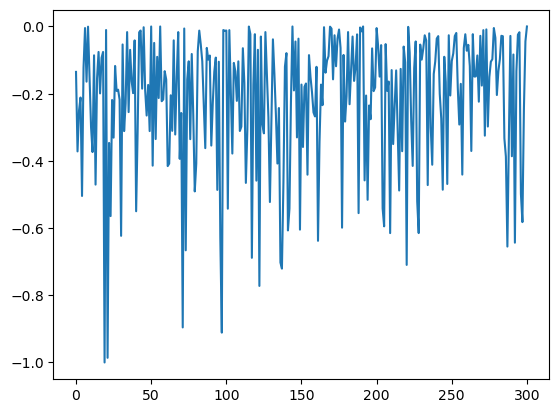

In [22]:
#### Notice how sign of H_samples[index]-y_ref matters

index = 0
plt.plot(a[index])
H_samples[index]-y_ref

array([[-0.08902387]])

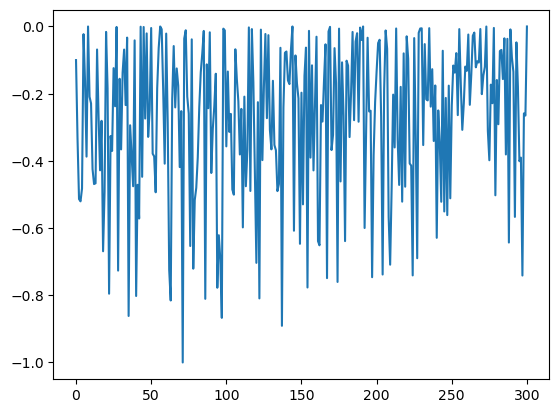

In [23]:
#### Notice how sign of H_samples[index]-y_ref matters

index = 1
plt.plot(a[index])
H_samples[index]-y_ref

array([[-0.10420719]])

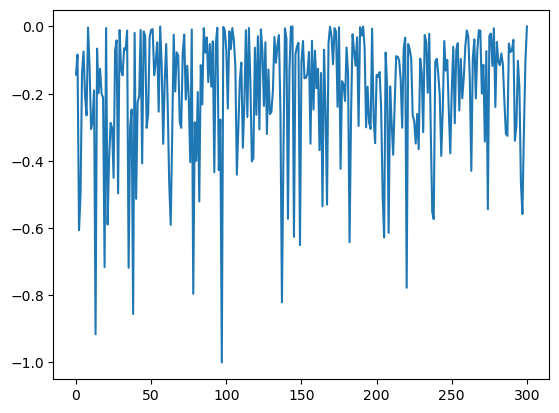

In [26]:
#### Notice how sign of H_samples[index]-y_ref matters

index = 100
plt.plot(a[index])
H_samples[index]-y_ref

In [30]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y / 3.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, 0], y_ref)

model1, model2, model3 = triplicated_model_LRP_compatible(best_model, a_ref)
y1 = model1.predict(M_samples[np.newaxis, index])
y2 = model2.predict(M_samples[np.newaxis, index])
y3 = model3.predict(M_samples[np.newaxis, index])

analyzer_gradient1 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model1)
analyzer_gradient2 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model2)
analyzer_gradient3 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model3)
a1 = np.zeros((samples, nx+1), dtype = np.float64)
a2 = np.zeros((samples, nx+1), dtype = np.float64)
a3 = np.zeros((samples, nx+1), dtype = np.float64)
a  = np.zeros((samples, nx+1), dtype = np.float64)

for sample in range(samples):
    a1[sample] = analyzer_gradient1.analyze(M_samples[sample][np.newaxis,:])
    a2[sample] = analyzer_gradient2.analyze(M_samples[sample][np.newaxis,:])
    a3[sample] = analyzer_gradient3.analyze(M_samples[sample][np.newaxis,:])
    a[sample]  = a1[sample] + a2[sample] + a3[sample]
    a[sample]  = a[sample] / np.max(np.abs(a[sample]))
    
y, y_ref, y-(y1+y2+y3)

2023-06-27 18:32:44.520532: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Relu' id:308 op device:{requested: '', assigned: ''} def:{{{node dense_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:32:44.676182: W tensorflow/c/c_api.cc:291] Operation '{name:'count_31/Assign' id:5801 op device:{requested: '', assigned: ''} def:{{{node count_31/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_31, count_31/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:32:44.872576: W te

2023-06-27 18:32:45.484761: W tensorflow/c/c_api.cc:291] Operation '{name:'dense13_8/kernel/Assign' id:5902 op device:{requested: '', assigned: ''} def:{{{node dense13_8/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense13_8/kernel, dense13_8/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:32:46.481123: W tensorflow/c/c_api.cc:291] Operation '{name:'dense21_8/MatMul' id:5929 op device:{requested: '', assigned: ''} def:{{{node dense21_8/MatMul}} = MatMul[T=DT_FLOAT, _has_manual_control_dependencies=true, transpose_a=false, transpose_b=false](dense11_8/Relu, dense21_8/MatMul/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will tr

2023-06-27 18:32:49.060955: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_108' id:6161 op device:{requested: '', assigned: ''} def:{{{node mul_108}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](ReadVariableOp_247, Cast_108)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:32:49.682866: W tensorflow/c/c_api.cc:291] Operation '{name:'kernel_58/Assign' id:6384 op device:{requested: '', assigned: ''} def:{{{node kernel_58/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_58, kernel_58/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-0

2023-06-27 18:32:52.548080: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients_78/MaxNeuronSelection_16/Max_grad/ones' id:6664 op device:{requested: '', assigned: ''} def:{{{node gradients_78/MaxNeuronSelection_16/Max_grad/ones}} = Fill[T=DT_INT32, _class=["loc:@MaxNeuronSelection_16/Max"], _has_manual_control_dependencies=true, index_type=DT_INT32](gradients_78/MaxNeuronSelection_16/Max_grad/Shape_1, gradients_78/MaxNeuronSelection_16/Max_grad/ones/Const)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 18:32:52.720656: W tensorflow/c/c_api.cc:291] Operation '{name:'MaxNeuronSelection_16/Max/reduction_indices' id:6550 op device:{requested: '', assigned: ''} def:{{{node MaxNeuronSelection_16/Max/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape:

(array([[0.07594802]], dtype=float32),
 array([[0.02531601]], dtype=float32),
 array([[0.02520931]], dtype=float32))

array([[0.05058768]])

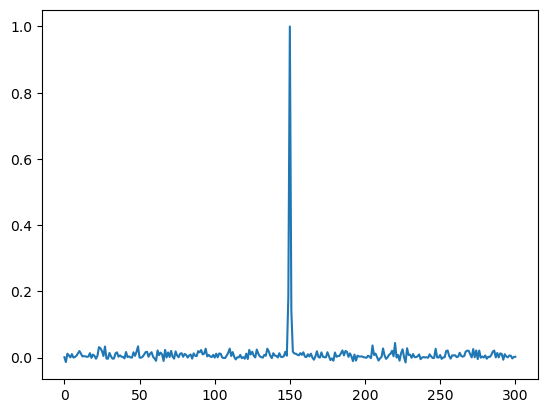

In [31]:
index = 0
plt.plot(a[index])
H_samples[index]-y_ref

array([[0.03755617]])

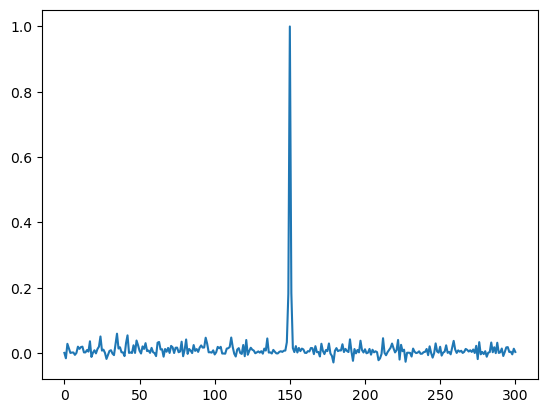

In [32]:
index = 1
plt.plot(a[index])
H_samples[index]-y_ref

array([[0.04918041]])

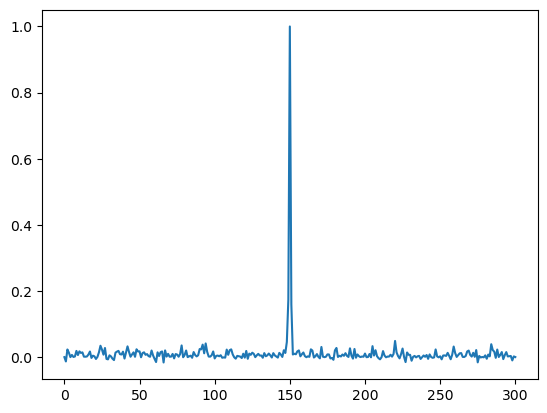

In [33]:
index = 2
plt.plot(a[index])
H_samples[index]-y_ref